In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from src.modules import conf, fit, spec, evl, pred
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
sns.set(style='ticks')
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [4]:
data = fit.load_pcls(
        conf["Athlete"]["name"],
        conf["Athlete"]["activity_type"],
        conf["Paths"]["pcl"],
    )

100%|██████████| 361/361 [00:01<00:00, 346.42it/s]


In [5]:
from src.heuristics import random_shooting
from src.heuristics import genetic_optimization

In [6]:
r_cross = conf['GO']['r_cross']
r_mut = conf['GO']['r_mut']

In [ ]:
train_df, test_df = fit.get_train_test_df(data,ratio=0.7)
test_df, valid_df = fit.get_test_valid_df(test_df)
print(len(train_df),len(test_df),len(valid_df))
speed = valid_df.enhanced_speed
valid_df.drop('enhanced_speed',axis=1,inplace=True)

In [20]:
_,_,rmse,cols, nrmse = random_shooting.random_shoot(
                          train_df=train_df,
                          test_df=test_df,
                          hmax=30,
                          endog='enhanced_speed',
                          )

100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


In [10]:
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(10, r_cross,r_mut ,sorted_cols,train_df,test_df,train_df.columns,'enhanced_speed')

 70%|███████   | 7/10 [07:57<02:55, 58.47s/it]

New best: 1.6428241771276544


 80%|████████  | 8/10 [08:57<01:57, 58.96s/it]

New best: 1.6408625741004874


100%|██████████| 10/10 [10:59<00:00, 65.95s/it]


In [22]:
form = random_shooting.get_form(list(best),endog='enhanced_speed')
# form = random_shooting.get_form(list(cols[rmse.index(np.min(rmse))]), endog='enhanced_speed')
# form = random_shooting.get_form(list(train_df.columns),endog='enhanced_speed')
# form = 'enhanced_speed ~ heart_rate + distance + enhanced_altitude + cadence + temp + wind_speed + wind_direct + rain + dist_diff + cadence_delayed + enhanced_altitude_delayed + slope_ascent + slope_descent + slope_steep -1'
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
evl.rmse(speed,pred_ols)

2.1367960662304673

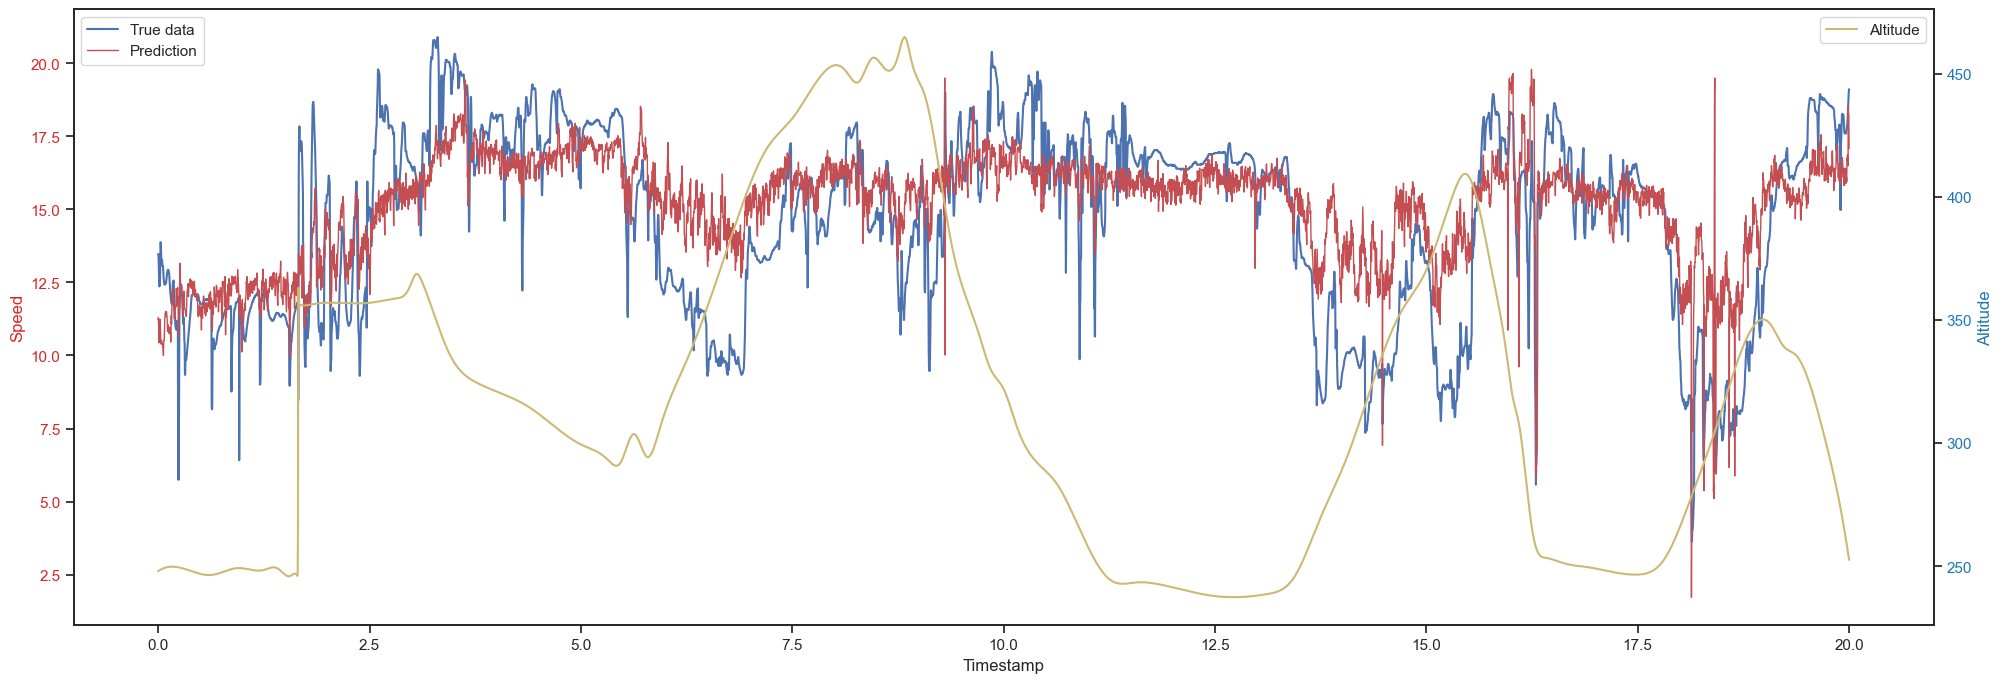

In [55]:
fig = evl.plot(df=valid_df,pred=pred_ols,endog='enhanced_speed',true_data=speed)